In [775]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import OrderedDict
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

# Chapter 8 Exercises

## Conceptual

**1.** Draw an example (of your own invention) of a partition of two- dimensional feature space that could result from recursive binary splitting. Your example should contain at least six regions. Draw a decision tree corresponding to this partition. Be sure to label all aspects of your figures, including the regions $R1, R2, . . .,$ the cutpoints $t1,t2,...,$ and so forth.

*_Hint: Your result should look something like Figures 8.1 and 8.2._*

                   x1<=5
                   |    |
             x2<=1.5    x1<=11  
             |     |    |    |
        x1<=2.5   22    14    x2<=4
       |      |              |     | 
       55    42              25    7

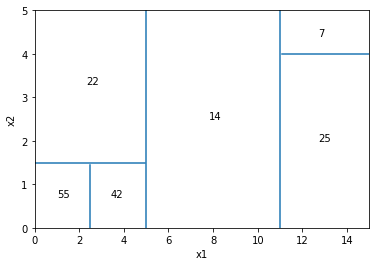

In [98]:
# A partition of the predictor space

# split lines
plt.axhline(y=4, xmin=1, xmax=0.74)
plt.axvline(x=5)
plt.axvline(x=2.5, ymin=0, ymax=0.29)
plt.axvline(x=11)
plt.axhline(y=1.5, xmin=0, xmax=0.33)

# axis and labels
plt.axis([0,15,0,5])
plt.xlabel("x1")
plt.ylabel("x2")

# label terminal nodes
plt.text(1, 0.7, '55')
plt.text(3.4, 0.7, '42')
plt.text(2.3, 3.3, '22')
plt.text(7.8, 2.5, '14')
plt.text(12.7, 2, '25')
plt.text(12.7, 4.4, '7')
plt.show();

**2.** It is mentioned in Section 8.2.3 that boosting using depth-one trees (or stumps) leads to an additive model. Explain why this is the case.

>Additive models are a sum of univariate regression functions over the variables (in the regression case). Similarly, boosting using depth-one trees is a sum of single variable models.

**3.** Consider the Gini index, classification error, and cross-entropy in a simple classification setting with two classes. Create a single plot that displays each of these quantities as a function of ${\hat p}_{m1}$. The x-axis should display ${\hat p}_{m1}$, ranging from 0 to 1, and the y-axis should display the value of the Gini index, classification error, and entropy.

In [113]:
p = np.linspace(0.0001, 0.9999, 100)

gini = p*(1-p)*2
entropy = -(p * np.log(p) + (1 - p) * np.log(1 - p))
class_err = 1 - np.maximum(p, 1 - p)

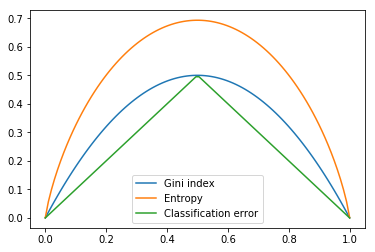

In [120]:
plt.plot(p, gini)
plt.plot(p, entropy)
plt.plot(p, class_err)
plt.legend(('Gini index', 'Entropy', 'Classification error'),loc='best');

**4.** See answer to question 1.

**5.** Suppose we produce ten bootstrapped samples from a data set containing red and green classes. We then apply a classification tree to each bootstrapped sample and, for a specific value of X, produce 10 estimates of P(Class is Red|X).

There are two common ways to combine these results together into a single class prediction. One is the majority vote approach discussed in this chapter. The second approach is to classify based on the average probability. In this example, what is the final classification under each of these two approaches?

In [140]:
p_red = [0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75]

# majority vote
print(sum(1 for i in p_red if i>=0.5)/len(p_red))

# average
print(np.average(p_red))

0.6
0.45


**6.** Provide a detailed explanation of the algorithm that is used to fit a regression tree.

First, we select the predictor $X_j$ and the cutpoint $s$ such that splitting the predictor space into the regions ${X|X_j<s}$ and ${X|X_j>=s}$ leads to the greatest possible reduction in RSS.

Next, we repeat the process, looking for the best predictor and best cutpoint in order to split the data further so as to minimize the RSS within each of the resulting regions.

This process continues until a stopping point is reached; for instance, we may continue until no region contains more that five observations.

Once the regions have been created, we predict the response for a given test observation using the mean of the training observations in the region to which that test observation belongs.

## Applied

**7.** In the lab, we applied random forests to the `Boston` data using `mtry=6` and using `ntree=25` and `ntree=500`. Create a plot displaying the test error resulting from random forests on this data set for a more com-prehensive range of values for `mtry` and `ntree`. You can model your plot after Figure 8.10. Describe the results obtained.

>m=p/2 and m=sqrt(p) perform the best.

In [509]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv").drop('Unnamed: 0', axis=1)
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [510]:
X = df.iloc[:, :-1]
y = df['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [511]:
err_rate1 = OrderedDict()
err_rate2 = OrderedDict()
err_rate3 = OrderedDict()

# m=p
for i in range(1, 506, 5):
    rf = RandomForestRegressor(random_state=1,
                              n_estimators=i).fit(X_train, y_train)
    err_rate1[i] = mean_squared_error(y_test, rf.predict(X_test))

# m=p/2
for i in range(1, 506, 5):
    rf = RandomForestRegressor(random_state=1, max_features=int(len(X_train.columns)/2),
                              n_estimators=i).fit(X_train, y_train)
    err_rate2[i] = mean_squared_error(y_test, rf.predict(X_test))

# m=sqrt(p)
for i in range(1, 506, 5):
    rf = RandomForestRegressor(random_state=1, max_features='sqrt',
                              n_estimators=i).fit(X_train, y_train)
    err_rate3[i] = mean_squared_error(y_test, rf.predict(X_test))

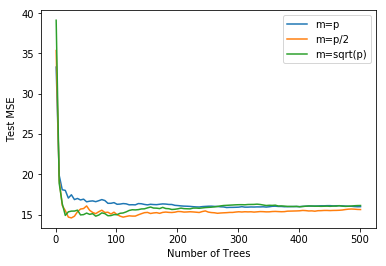

In [512]:
# plot our dictionaries of results
plt.plot(*zip(*sorted(err_rate1.items())))
plt.plot(*zip(*sorted(err_rate2.items())))
plt.plot(*zip(*sorted(err_rate3.items())))
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.legend(('m=p', 'm=p/2', 'm=sqrt(p)'),loc='best');
plt.show()

In [518]:
print("# of trees and error rate for each split method.")
print(min(err_rate1.items(), key=lambda x: x[1]))
print(min(err_rate2.items(), key=lambda x: x[1]))
print(min(err_rate3.items(), key=lambda x: x[1]))

# of trees and error rate for each split method.
(281, 15.899361810826397)
(26, 14.61327642257408)
(66, 14.828831941404708)


In [280]:
# another approach for this problem could be gridsearch
# m (max_features) and # of trees (n_estimators)
# this example is not complete

from sklearn.model_selection import GridSearchCV

rff = GridSearchCV(RandomForestRegressor(random_state=1),
                  param_grid={'max_features': ['auto','sqrt'],
                             'n_estimators': range(1,11)},
                   scoring='neg_mean_squared_error',
                  return_train_score=True)

rff.fit(X_train, y_train)
results = rff.cv_results_

**8.** In the lab, a classification tree was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will seek to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

**(a)** Split the data set into a training set and a test set.

**(b)** Fit a regression tree to the training set. Plot the tree, and interpret the results. What test error rate do you obtain?

In [284]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Carseats.csv")

df=df.drop(columns=['Unnamed: 0'])
print("Shape of df: " + str(df.shape))
df.head()

Shape of df: (400, 11)


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [293]:
# create our categorical variables with pd.get_dummies

# looks like you don't need to pass column list of categorical, so don't need this
# df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'], drop_first=True)

# use this instead. it's more simple
df = pd.get_dummies(df, drop_first=True)


X = df.drop(['Sales'], axis=1).astype('float64')
y = df.Sales

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
CompPrice           400 non-null float64
Income              400 non-null float64
Advertising         400 non-null float64
Population          400 non-null float64
Price               400 non-null float64
Age                 400 non-null float64
Education           400 non-null float64
ShelveLoc_Good      400 non-null float64
ShelveLoc_Medium    400 non-null float64
Urban_Yes           400 non-null float64
US_Yes              400 non-null float64
dtypes: float64(11)
memory usage: 34.5 KB


In [294]:
# split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=17)

In [367]:
# fit tree and get test mse

dtr = DecisionTreeRegressor(random_state=17).fit(X_train, y_train)

mean_squared_error(y_test, dtr.predict(X_test))

6.668220999999999

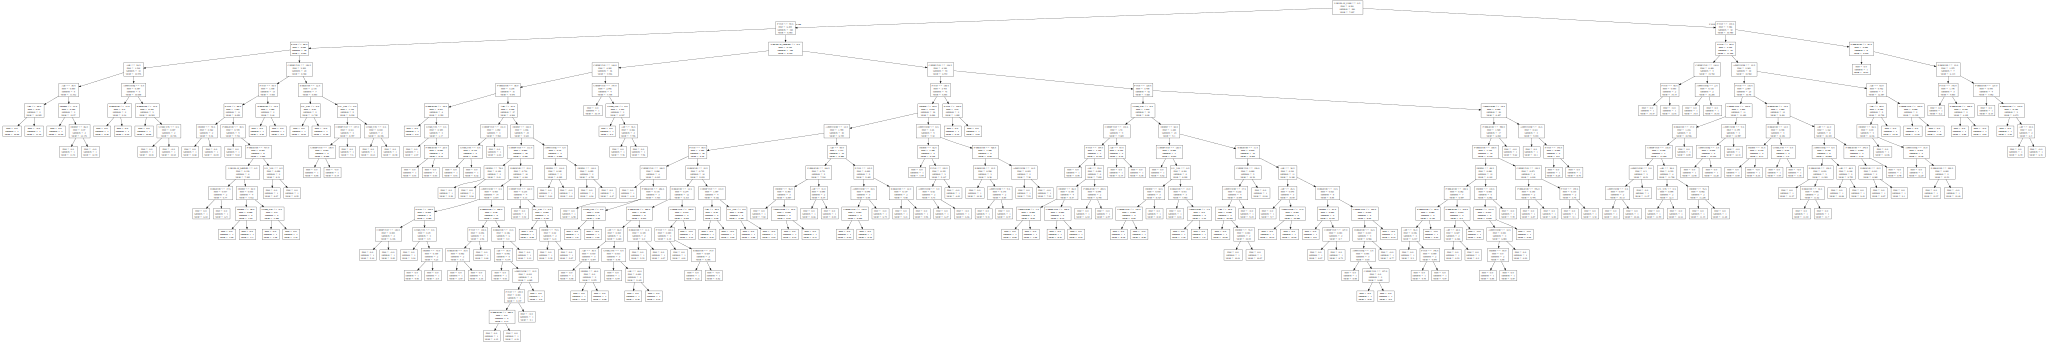

In [368]:
# massive tree. completely unpruned

# plot tree

export_graphviz(dtr, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [369]:
# number of terminal nodes
len(np.unique(dtr.apply(X)))

200

**(c)** Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test error rate?

>Yes, pruning improves test mse from 6.67 to 5.16

NOTE: pruning is not available in `sklearn` like the `tree` package in `R`. But you can tweak some paramaters within the package to get something similar. Check out [this issue discussion](https://github.com/scikit-learn/scikit-learn/issues/8399) in the sklearn github. In the below example, we evaluated a number of `max_leaf_nodes` via cross-validation (through GridSearch). From there we are able to find the best model via CV and evaluate on our test set.

In [370]:
# examine max_leaf_nodes for CV
# pruning not really in sklearn.tree
# https://github.com/scikit-learn/scikit-learn/issues/8399

from sklearn.model_selection import GridSearchCV

# 'max_depth' : range(1, 21) #could use max_depth to prune as well                       

dtr_cv = GridSearchCV(DecisionTreeRegressor(random_state=17),
                  param_grid={'max_leaf_nodes' : range(2, 51)},
                  return_train_score=True)

dtr_cv.fit(X_train, y_train)
results = dtr_cv.cv_results_

In [371]:
# best model has max_leaf_nodes=12
dtr_cv.best_estimator_

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=12, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best')

In [372]:
# fit our best model from CV and get test mse

dtr_cv_best = dtr_cv.best_estimator_.fit(X_train, y_train)

mean_squared_error(y_test, dtr_cv_best.predict(X_test))

5.163770420742659

In [373]:
# number of terminal nodes
len(np.unique(dtr_cv_best.apply(X)))

12

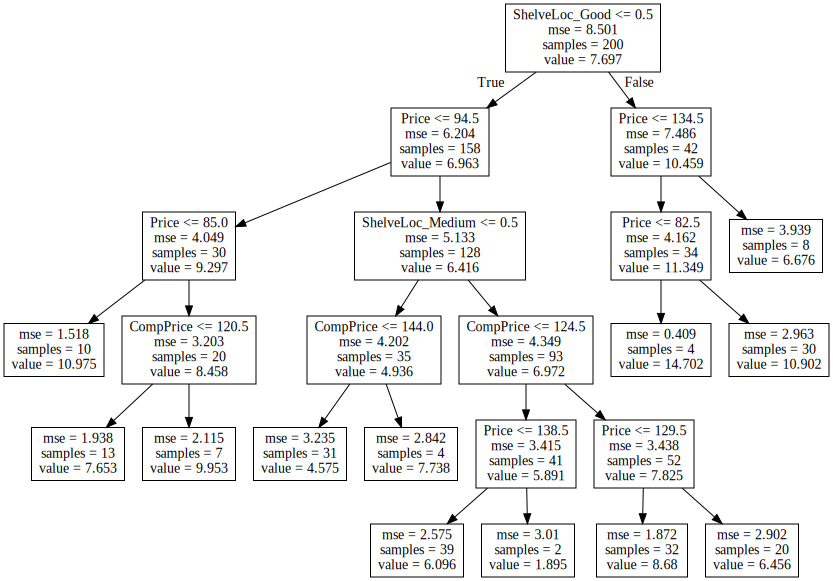

In [374]:
# plot cv selected tree

export_graphviz(dtr_cv_best, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

**(d)** Use the bagging approach in order to analyze this data. What test error rate do you obtain? Use the `importance()` function to determine which variables are most important.

In [383]:
bag_reg = BaggingRegressor(random_state=17).fit(X_train, y_train)

mean_squared_error(y_test, bag_reg.predict(X_test))

3.357818504999999

In [388]:
feature_imp = np.mean([tree.feature_importances_ for tree in bag_reg.estimators_], axis=0)
    
pd.Series(feature_imp, X_train.columns).sort_values(ascending=False)

Price               0.379421
ShelveLoc_Good      0.211286
CompPrice           0.110055
Age                 0.061230
Advertising         0.055010
ShelveLoc_Medium    0.049553
Population          0.042714
Income              0.039262
Education           0.033377
Urban_Yes           0.014380
US_Yes              0.003711
dtype: float64

**(e)** Use random forests to analyze this data. What test error rate do you obtain? Use the `importance()` function to determine which variables are most important. Describe the effect of $m$, the number of variables considered at each split, on the error rate obtained.

>Limiting the number of $m$ in random forests (where m=sqrt(p)) improves on the test error relative to bagging (m=p). This is because random forest split consideration allows the aggregated trees to be more decorrelated from each other, compared to bagging. Selecting a smaller number of predictors on which to split leads to less variance and therefore (typically) smaller test mse.

In [396]:
rf = RandomForestRegressor(random_state=1).fit(X_train, y_train)

mean_squared_error(y_test, rf.predict(X_test))

3.1794935399999997

In [397]:
pd.Series(rf.feature_importances_, X.columns).sort_values(ascending=False)

Price               0.329167
ShelveLoc_Good      0.230911
CompPrice           0.125805
Age                 0.089293
Income              0.050508
Advertising         0.050020
Population          0.049253
ShelveLoc_Medium    0.036232
Education           0.026357
Urban_Yes           0.006625
US_Yes              0.005829
dtype: float64

**9.** This problem involves the OJ data set which is part of the ISLR package.

**(a)** Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [519]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/OJ.csv").drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(1070, 18)


,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


In [520]:
# check for categoricals
df.describe(include='object')

,Purchase,Store7
count,1070,1070
unique,2,2
top,CH,No
freq,653,714


In [521]:
# get dummies
df = pd.get_dummies(df, drop_first=True)


X = df.drop(['Purchase_MM'], axis=1).astype('float64')
y = df.Purchase_MM

X.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 17 columns):
WeekofPurchase    1070 non-null float64
StoreID           1070 non-null float64
PriceCH           1070 non-null float64
PriceMM           1070 non-null float64
DiscCH            1070 non-null float64
DiscMM            1070 non-null float64
SpecialCH         1070 non-null float64
SpecialMM         1070 non-null float64
LoyalCH           1070 non-null float64
SalePriceMM       1070 non-null float64
SalePriceCH       1070 non-null float64
PriceDiff         1070 non-null float64
PctDiscMM         1070 non-null float64
PctDiscCH         1070 non-null float64
ListPriceDiff     1070 non-null float64
STORE             1070 non-null float64
Store7_Yes        1070 non-null float64
dtypes: float64(17)
memory usage: 142.2 KB


,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Purchase_MM,Store7_Yes
0,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24,1,0,0
1,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24,1,0,0
2,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23,1,0,0
3,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00,1,1,0
4,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00,0,0,1


In [522]:
# split data into 800 train obs. remaining as test obs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=len(X)-800, random_state=17)

# confirm shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 17)
(800,)
(270, 17)
(270,)


**(b)** Fit a tree to the training data, with `Purchase` as the response and the other variables as predictors. Use the `summary()` function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [523]:
# I selected max_depth and max_leaf_nodes to match the R output
# this is bc there is no pruning in sklearn trees

dtc = DecisionTreeClassifier(random_state=17,
                            max_depth=4,
                            max_leaf_nodes=7).fit(X_train, y_train)

# number of terminal nodes
len(np.unique(dtc.apply(X)))

7

In [524]:
# evaluated on the training data

conf_matrix = pd.crosstab(dtc.predict(X_train), y_train, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(dtc.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 7
Error rate (misclassification): 0.15625 = 125 / 800
Accuracy: 0.84375


Actual,0,1,All
Predicted,,,
0,431,66,497
1,59,244,303
All,490,310,800


**(c)** Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.

>Come back to this one. Command not as easily available in Python as in R. See pg.325 in ISLR for how to do it in R.

**(d)** Create a plot of the tree, and interpret the results.

>Brand loyalty and price difference are the most imporant predictors.

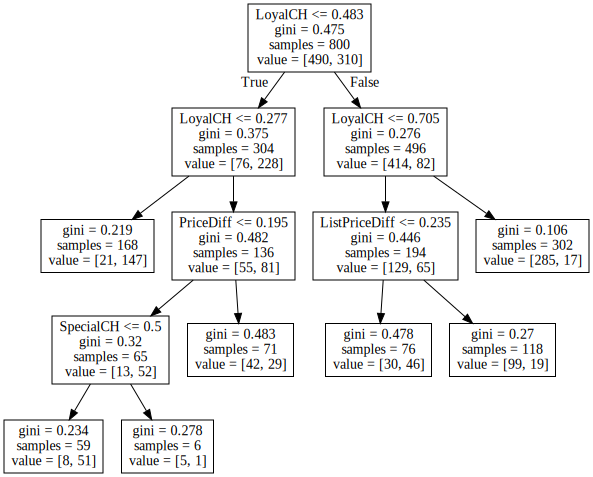

In [434]:
export_graphviz(dtc, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

**(e)** Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [525]:
# evaluated on the test data

conf_matrix = pd.crosstab(dtc.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(dtc.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 7
Error rate (misclassification): 0.23333333333333334 = 63 / 270
Accuracy: 0.7666666666666667


Actual,0,1,All
Predicted,,,
0,135,35,170
1,28,72,100
All,163,107,270


**(f)** Apply the `cv.tree()` function to the training set in order to determine the optimal tree size.

In [526]:
dtc_cv = GridSearchCV(DecisionTreeClassifier(random_state=17),
                  param_grid={'max_leaf_nodes' : range(2, 51),
                             'max_depth': range(2, 51)},
                  return_train_score=True)

dtc_cv.fit(X_train, y_train)
results = dtr_cv.cv_results_

In [527]:
dtc_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

**(g)** Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

**Evaluated using CV**

In [528]:
from sklearn.model_selection import cross_val_score

err_rate_cv = OrderedDict()

for i in range(2, 150):
    dtc_b = DecisionTreeClassifier(random_state=17,
                              max_leaf_nodes=i).fit(X_train, y_train)
    err_rate_cv[i] = 1-cross_val_score(dtc_b, X_train, y_train, cv=10).mean() # cv misclassification rate

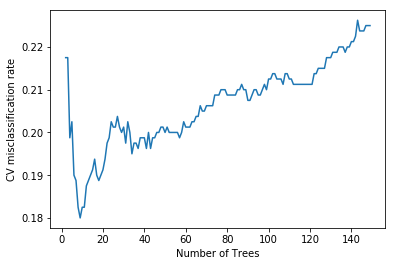

In [530]:
# plot
plt.plot(*zip(*sorted(err_rate_cv.items())))
plt.xlabel('Number of Trees')
plt.ylabel('CV misclassification rate')
plt.show()

**(h)** Which tree size corresponds to the lowest cross-validated classification error rate?

In [534]:
# number of trees with lowest CV error rate
min(err_rate_cv, key=err_rate_cv.get)

9

**Evaluated using test set**

In [531]:
err_rate = OrderedDict()

for i in range(2, 300):
    dtc_b = DecisionTreeClassifier(random_state=17,
                              max_leaf_nodes=i).fit(X_train, y_train)
    err_rate[i] = 1-dtc_b.score(X_test, y_test) # test misclassification rate

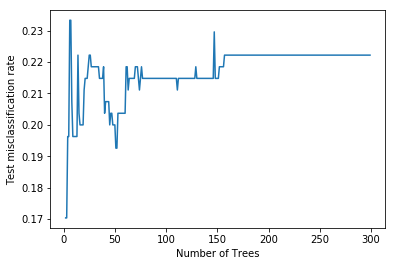

In [532]:
# plot
plt.plot(*zip(*sorted(err_rate.items())))
plt.xlabel('Number of Trees')
plt.ylabel('Test misclassification rate')
plt.show()

In [533]:
# number of trees with lowest test error rate
min(err_rate, key=err_rate.get)

2

**(i)** Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

>in `sklearn.tree.DecisionTreeClassifier` the parameter `max_leaf_nodes` equals terminal nodes

In [535]:
# model summary

dtc_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best')

**(j)** Compare the training error rates between the pruned and unpruned trees. Which is higher?

>Slightly better training error rate. **0.1487** for pruned and **0.1562** for unpruned.

In [536]:
# best (pruned) model on the training data

conf_matrix = pd.crosstab(dtc_cv.best_estimator_.predict(X_train), y_train, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(dtc_cv.best_estimator_.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 9
Error rate (misclassification): 0.14875 = 119 / 800
Accuracy: 0.85125


Actual,0,1,All
Predicted,,,
0,454,83,537
1,36,227,263
All,490,310,800


**(k)** Compare the test error rates between the pruned and unpruned trees. Which is higher?

>Pruned model performed better on test data. **0.1963** for pruned and **0.2333** for unpruned.

In [537]:
# best (pruned) model on the test data

conf_matrix = pd.crosstab(dtc_cv.best_estimator_.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
terminal_nodes = len(np.unique(dtc_cv.best_estimator_.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
conf_matrix

Number of terminal nodes: 9
Error rate (misclassification): 0.1962962962962963 = 53 / 270
Accuracy: 0.8037037037037037


Actual,0,1,All
Predicted,,,
0,147,37,184
1,16,70,86
All,163,107,270


**10.** We now use boosting to predict `Salary` in the `Hitters` data set.

**(a)** Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [556]:
df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
print("Shape of dataframe: " + str(df.shape))
df.head()

Shape of dataframe: (263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [558]:
# log salary

df['Salary'] = np.log(df.Salary)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A


**(b)** Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [559]:
# first we've got to get dummies for our categorical variables

# get dummies
df = pd.get_dummies(df, drop_first=True)


X = df.drop(['Salary'], axis=1).astype('float64')
y = df.Salary

X.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null float64
Division_W     263 non-null float64
NewLeague_N    263 non-null float64
dtypes: float64(19)
memory usage: 41.1+ KB


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,6.163315,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,6.173786,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,6.214608,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,4.516339,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,6.620073,0,1,0


In [560]:
# next
# split data into 200 train obs. remaining as test obs
# here, we take random sample. not first 200 (ordinal)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=len(X)-200, random_state=17)

# confirm shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(200, 19)
(200,)
(63, 19)
(63,)


**(c)** Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

In [599]:
err_rate_gbr = OrderedDict()

for i in np.linspace(10e-10, 0.5, 100):
    gbrv = GradientBoostingRegressor(learning_rate=i,
                                random_state=17,
                                n_estimators=1000).fit(X_train, y_train)
    err_rate_gbr[i] = mean_squared_error(y_train, gbrv.predict(X_train))

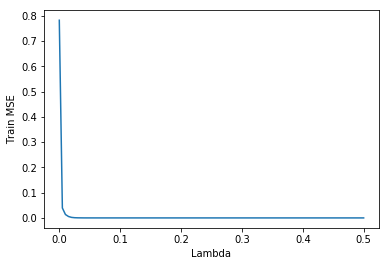

In [600]:
# plot
plt.plot(*zip(*sorted(err_rate_gbr.items())))
plt.xlabel('Lambda')
plt.ylabel('Train MSE')
plt.show()

**(d)** Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

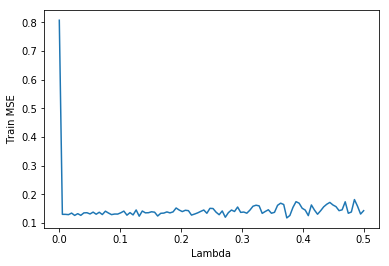

In [602]:
err_rate_gbr_t = OrderedDict()

for i in np.linspace(10e-10, 0.5, 100):
    gbrv_t = GradientBoostingRegressor(learning_rate=i,
                                random_state=17,
                                n_estimators=1000).fit(X_train, y_train)
    # use test sets here
    err_rate_gbr_t[i] = mean_squared_error(y_test, gbrv_t.predict(X_test))
    
# plot
plt.plot(*zip(*sorted(err_rate_gbr_t.items())))
plt.xlabel('Lambda')
plt.ylabel('Train MSE')
plt.show()

In [604]:
# minimum test error is 0.117
print(min(err_rate_gbr_t.items(), key=lambda x: x[1]))

(0.373737373989899, 0.11730132633933925)


**(e)** Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

>Both LR and LR+lasso have worse test MSE than our Gradient Boosting Regressor

In [606]:
# plain 'ol linear regression

lr = LinearRegression().fit(X_train, y_train)

mean_squared_error(y_test, lr.predict(X_test))

0.3627832254546815

In [610]:
# linear reg with lasso

lr_las = Lasso(alpha=1).fit(X_train, y_train)

mean_squared_error(y_test, lr_las.predict(X_test))

0.4252851493261184

**(f)** Which variables appear to be the most important predictors in the boosted model?

In [616]:
# let's GridSearchCV api to get our best model from a search of lambdas

gbr_cv = GridSearchCV(GradientBoostingRegressor(random_state=17,
                                                max_depth=4,
                                                n_estimators=1000),
                    param_grid={'learning_rate' : np.linspace(10e-10, 0.5, 100)},
                  return_train_score=True)

gbr_cv.fit(X_train, y_train)
results = gbr_cv.cv_results_

In [617]:
# model summary

gbr_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.21212121269696968, loss='ls', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=17, subsample=1.0, verbose=0,
             warm_start=False)

In [623]:
# test MSE from or best model select via CV

mean_squared_error(y_test, gbr_cv.best_estimator_.predict(X_test))

0.1515630218079566

In [618]:
pd.Series(gbr_cv.best_estimator_.feature_importances_, X.columns).sort_values(ascending=False)

RBI            0.017449
CWalks         0.016170
Assists        0.016013
CHmRun         0.015508
CRuns          0.014853
PutOuts        0.014363
Hits           0.012883
AtBat          0.012269
CHits          0.011898
Walks          0.011270
Runs           0.011179
CAtBat         0.010984
HmRun          0.009821
Errors         0.009600
CRBI           0.009552
Years          0.008430
Division_W     0.001172
League_N       0.000882
NewLeague_N    0.000702
dtype: float64

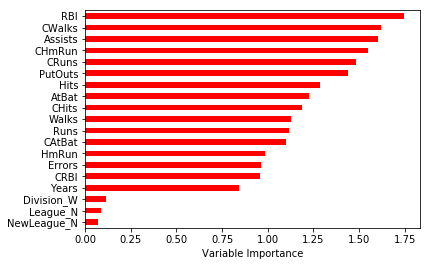

In [620]:
# variable importance plotted

Importance = pd.DataFrame({'Importance':gbr_cv.best_estimator_.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

**(g)** Now apply bagging to the training set. What is the test set MSE for this approach?

>The test MSE is slightly worse than Boosting, but better than both LR and LR+lasso.

In [622]:
bag_reg = BaggingRegressor(random_state=17,
                           max_features=13).fit(X_train, y_train)

mean_squared_error(y_test, bag_reg.predict(X_test))

0.1579178149785341

**11.** This question uses the `Caravan` data set.

**(a)** Create a training set consisting of the first 1,000 observations,
and a test set consisting of the remaining observations.

In [677]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Caravan.csv", index_col=0)#.drop('Unnamed: 0', axis=1)
# convert our categorical
df = pd.get_dummies(df, drop_first=True)
print("Shape of df: " + str(df.shape))
df.head()

Shape of df: (5822, 86)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase_Yes
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


Here, were are not taking a random sample to create our test and train sets. But, rather, as directed in the question, we are taking the first 1000 rows as our train set and the remainder as our test set. Normally we would use `sklearn.train_test_split` or `pd.sample` to get sampled train and test sets.

In [684]:
train = df.iloc[:1000,:]
test = df.drop(train.index)

print(train.shape)
print(test.shape)

(1000, 86)
(4822, 86)


In [737]:
X_train = train.drop(['Purchase_Yes'], axis=1).astype('float64')
y_train = train.Purchase_Yes
X_test = test.drop(['Purchase_Yes'], axis=1).astype('float64')
y_test = test.Purchase_Yes

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1000, 85)
(1000,)
(4822, 85)
(4822,)


**(b)** Fit a boosting model to the training set with `Purchase` as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

In [687]:
gbc = GradientBoostingClassifier(random_state=17,
                                n_estimators=1000,
                                learning_rate=0.01).fit(X_train, y_train)

In [710]:
pd.Series(gbc.feature_importances_*100, X_train.columns).sort_values(ascending=False)



MOSTYPE     7.461566e+00
MGODGE      4.558420e+00
PPERSAUT    4.245581e+00
ABRAND      4.062608e+00
MKOOPKLA    4.039378e+00
MOPLHOOG    3.996630e+00
PLEVEN      3.670544e+00
PWAPART     3.273668e+00
MBERARBG    3.047556e+00
AMOTSCO     3.007705e+00
MSKB1       2.945327e+00
PGEZONG     2.464978e+00
PBRAND      2.410583e+00
MGODPR      2.182047e+00
MBERMIDD    2.161161e+00
MINKM30     1.884654e+00
MSKA        1.872444e+00
MINK3045    1.784942e+00
PPLEZIER    1.760985e+00
MFGEKIND    1.745220e+00
MFWEKIND    1.731099e+00
MOSHOOFD    1.728677e+00
PBYSTAND    1.682273e+00
MRELGE      1.677448e+00
MGODRK      1.651958e+00
MFALLEEN    1.623035e+00
AFIETS      1.446264e+00
MINK7512    1.442373e+00
APLEZIER    1.431756e+00
MZFONDS     1.239791e+00
                ...     
MGEMLEEF    3.478810e-01
PZEILPL     3.205353e-01
ALEVEN      2.979555e-01
MOPLLAAG    2.887450e-01
PWALAND     2.539706e-01
AGEZONG     2.351313e-01
AZEILPL     2.218867e-01
AWALAND     2.128371e-01
MAUT0       2.088694e-01


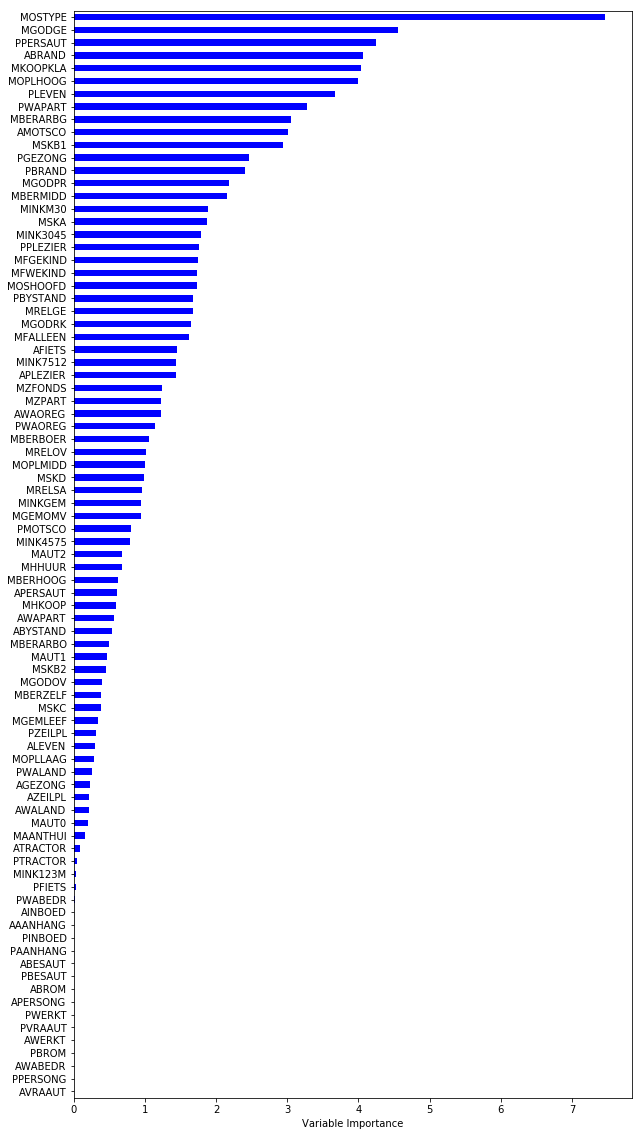

In [712]:
# variable importance plotted

Importance = pd.DataFrame({'Importance':gbc.feature_importances_*100}, index=X_train.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='b', )
plt.rcParams['figure.figsize'] = [10, 10]
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

**(c)** Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20%. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [732]:
# get 0's and 1's prediction based on threshold

np.where(gbc.predict_proba(X_test)[:,1] > 0.2, 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [752]:
# get our predictions to be loaded for our cofusion matrix

pred = np.where(gbc.predict_proba(X_test)[:,1] > 0.2, 1, 0)

In [753]:
# confusion matrix with 20% treshold

conf_matrix = pd.crosstab(pred, y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
recall = TP/(TP+FN)
#terminal_nodes = len(np.unique(dtc_cv.best_estimator_.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
conf_matrix

Number of terminal nodes: 9
Error rate (misclassification): 0.09332227291580257 = 450 / 4822
Accuracy: 0.9066777270841975
Recall: 0.1314878892733564


Actual,0,1,All
Predicted,,,
0,4334,251,4585
1,199,38,237
All,4533,289,4822


What fraction of the people predicted to make a purchase do in fact make one?

This metric is also known as recall, sensitivity or True Positive Rate (TPR). And is calculated by TP/(TP+FN).

Of all those that were positive, what % did your model capture.

In [744]:
print(str(conf_matrix.iloc[1][1]/conf_matrix.iloc[2][1]*100) + 
     " of people predicted to make a purchase in fact do make one.")

13.148788927335639 of people predicted to make a purchase in fact do make one.


How does this compare with the results obtained from applying KNN or logistic regression to this data set?

>Recall = 17% for logistic regression. This is not as good as our Boosting classifier recall of 13%.

In [750]:
# logistic regression

logr = LogisticRegression(random_state=17).fit(X_train, y_train)

pred = np.where(logr.predict_proba(X_test)[:,1] > 0.2, 1, 0)

In [751]:
# logistic regression confusion matrix with 20% treshold

conf_matrix = pd.crosstab(pred, y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
recall = TP/(TP+FN)
#terminal_nodes = len(np.unique(dtc_cv.best_estimator_.apply(X)))

print("Number of terminal nodes: " + str(terminal_nodes))
print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
conf_matrix

Number of terminal nodes: 9
Error rate (misclassification): 0.09850684363334716 = 475 / 4822
Accuracy: 0.9014931563666528
Recall: 0.17301038062283736


Actual,0,1,All
Predicted,,,
0,4297,239,4536
1,236,50,286
All,4533,289,4822


**12.** Apply boosting, bagging, and random forests to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

>We will use the `Smarket` data to predict and build a classifier of wether the market will be up or down.

>Using misclassification rate as your metric the order is as follows:
1. Boosting: 42.49 = 133 / 313
2. Random Forest: 46.96 = 147 / 313
3. Bagging: 49.20 = 154 / 313
4. Logistic Regression: 51.11 = 160 / 313

In [758]:
df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Smarket.csv", index_col=0)
# get dummies
df = pd.get_dummies(df, drop_first=True)
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Up
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,1
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,1
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,0
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,1
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,1


In [765]:
X = df.drop(['Direction_Up', 'Year', 'Today'], axis=1).astype('float64')
y = df.Direction_Up

# split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

**Boosting**

In [766]:
gbc = GradientBoostingClassifier(random_state=17,
                                max_depth=4,
                                n_estimators=5000).fit(X_train, y_train)

In [769]:
conf_matrix = pd.crosstab(gbc.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*(precision*recall)/(precision+recall)

print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("F1 score: " + str(f1))
conf_matrix

Error rate (misclassification): 0.4249201277955272 = 133 / 313
Accuracy: 0.5750798722044729
Recall: 0.64
Precision: 0.5485714285714286
F1 score: 0.5907692307692308


Actual,0,1,All
Predicted,,,
0,84,54,138
1,79,96,175
All,163,150,313


**Bagging**

In [773]:
bag = BaggingClassifier(random_state=17,
                        max_features=len(X_train.columns)).fit(X_train, y_train)

In [774]:
conf_matrix = pd.crosstab(bag.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*(precision*recall)/(precision+recall)

print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("F1 score: " + str(f1))
conf_matrix

Error rate (misclassification): 0.49201277955271566 = 154 / 313
Accuracy: 0.5079872204472844
Recall: 0.5
Precision: 0.487012987012987
F1 score: 0.4934210526315789


Actual,0,1,All
Predicted,,,
0,84,75,159
1,79,75,154
All,163,150,313


**Random Forest**

In [776]:
rf = RandomForestClassifier(random_state=17).fit(X_train, y_train)

In [777]:
conf_matrix = pd.crosstab(rf.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*(precision*recall)/(precision+recall)

print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("F1 score: " + str(f1))
conf_matrix

Error rate (misclassification): 0.4696485623003195 = 147 / 313
Accuracy: 0.5303514376996805
Recall: 0.5133333333333333
Precision: 0.5099337748344371
F1 score: 0.5116279069767442


Actual,0,1,All
Predicted,,,
0,89,73,162
1,74,77,151
All,163,150,313


**Logistic Regression**

In [778]:
logreg = LogisticRegression(random_state=17).fit(X_train, y_train)

In [779]:
conf_matrix = pd.crosstab(logreg.predict(X_test), y_test, rownames=['Predicted'],
           colnames=['Actual'], margins=True)

TN = conf_matrix.iloc[0][0]
TP = conf_matrix.iloc[1][1]
FN = conf_matrix.iloc[0][1]
FP = conf_matrix.iloc[1][0]
ALL = conf_matrix.iloc[2][2]
accuracy = (TP+TN)/ALL
error_rate = (FP+FN)/ALL
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*(precision*recall)/(precision+recall)

print("Error rate (misclassification): " + str(error_rate) + 
     " = " + str(FP+FN) + " / " + str(ALL))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))
print("F1 score: " + str(f1))
conf_matrix

Error rate (misclassification): 0.5111821086261981 = 160 / 313
Accuracy: 0.48881789137380194
Recall: 0.86
Precision: 0.48134328358208955
F1 score: 0.6172248803827751


Actual,0,1,All
Predicted,,,
0,24,21,45
1,139,129,268
All,163,150,313
